In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from pathlib import Path


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Unzip dataset
!unzip '/content/gdrive/My Drive/FoodRecognition.zip'

Archive:  /content/gdrive/My Drive/FoodRecognition.zip
  inflating: test/apple/Image_1.jpg  
  inflating: test/apple/Image_10.jpg  
  inflating: test/apple/Image_2.jpg  
  inflating: test/apple/Image_3.jpg  
  inflating: test/apple/Image_4.jpg  
  inflating: test/apple/Image_5.jpg  
  inflating: test/apple/Image_6.JPG  
  inflating: test/apple/Image_7.jpg  
  inflating: test/apple/Image_8.jpg  
  inflating: test/apple/Image_9.jpg  
  inflating: test/banana/Image_1.jpg  
  inflating: test/banana/Image_10.jpg  
  inflating: test/banana/Image_2.jpg  
  inflating: test/banana/Image_3.jpg  
  inflating: test/banana/Image_4.jpg  
  inflating: test/banana/Image_5.jpg  
  inflating: test/banana/Image_6.jpg  
  inflating: test/banana/Image_8.jpg  
  inflating: test/banana/Image_9.jpg  
  inflating: test/beetroot/Image_1.jpg  
  inflating: test/beetroot/Image_10.jpg  
  inflating: test/beetroot/Image_2.jpg  
  inflating: test/beetroot/Image_3.jpg  
  inflating: test/beetroot/Image_4.jpg  
  infl

In [4]:
dataset_dir = '/content/DATASET'

In [5]:
# Direktori untuk train, test, and validation
train_dir = '/content/DATASET/train'
test_dir = '/content/DATASET/test'
val_dir = '/content/DATASET/validation'

In [6]:
# Proses filepath
def image_processing(filepaths):
    df = pd.DataFrame(filepaths, columns=['Filepath'])
    df['Label'] = df['Filepath'].apply(lambda x: Path(x).parent.name)
    return df

In [7]:
# Definisikan Size gambar dan batch size
image_size = (224, 224)
batch_size = 32

In [8]:
# Filepath untuk training, testing, and validation
train_filepaths = [str(filepath) for filepath in Path(train_dir).rglob('*.jpg')]
test_filepaths = [str(filepath) for filepath in Path(test_dir).rglob('*.jpg')]
val_filepaths = [str(filepath) for filepath in Path(val_dir).rglob('*.jpg')]


In [9]:
# Process the filepaths
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [10]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

train_df.head(5)

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['eggplant' 'watermelon' 'carrot' 'garlic' 'sweetpotato' 'capsicum'
 'ginger' 'jalepeno' 'cabbage' 'potato' 'pineapple' 'raddish' 'soy beans'
 'banana' 'pomegranate' 'onion' 'bell pepper' 'pear' 'cucumber' 'grapes'
 'lettuce' 'orange' 'sweetcorn' 'paprika' 'lemon' 'corn' 'peas'
 'chilli pepper' 'cauliflower' 'kiwi' 'beetroot' 'spinach' 'tomato'
 'apple' 'turnip' 'mango']


,Filepath,Label
0,/content/DATASET/train/eggplant/Image_55.jpg,eggplant
1,/content/DATASET/train/eggplant/Image_56.jpg,eggplant
2,/content/DATASET/train/eggplant/Image_28.jpg,eggplant
3,/content/DATASET/train/eggplant/Image_89.jpg,eggplant
4,/content/DATASET/train/eggplant/Image_35.jpg,eggplant


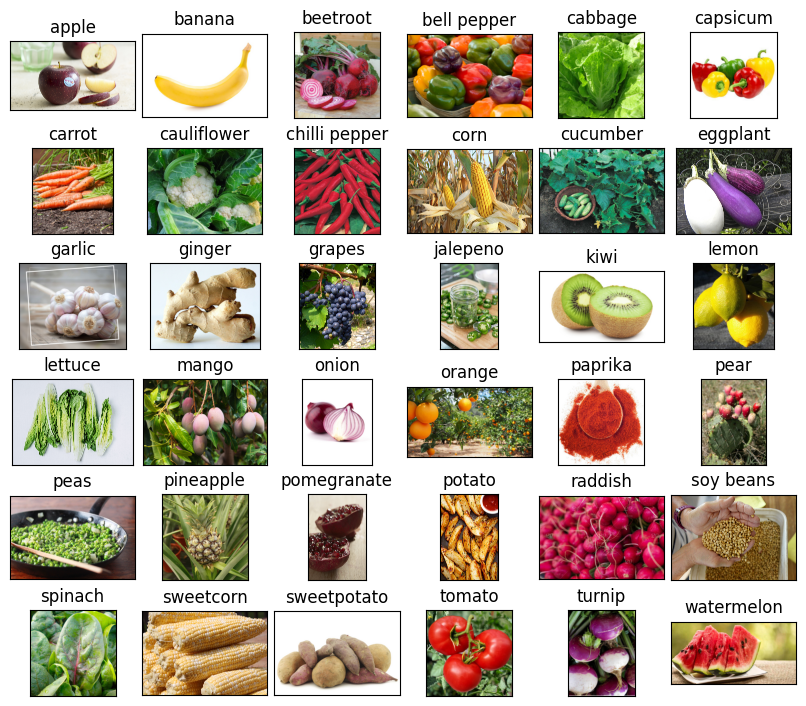

In [11]:
# Randomly select one image per category
df_unique = train_df.groupby("Label").first().reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize=12)
plt.tight_layout(pad=0.5)
plt.show()

In [12]:
# Load dan preprocess gambar
def preprocess_image(filepath):
    image = cv2.imread(filepath)
    image = cv2.resize(image, image_size)
    image = image / 255.0
    return image

In [13]:
X_train = []
y_train = []
for filepath in train_df['Filepath']:
    try:
        image = preprocess_image(filepath)
        X_train.append(image)
        label = train_df[train_df['Filepath'] == filepath]['Label'].values[0]
        y_train.append(label)
    except Exception as e:
        print(f"Error processing image {filepath}: {str(e)}")

Error processing image /content/DATASET/train/bell pepper/Image_56.jpg: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [14]:
labels = train_df['Label'].unique()
label_to_index = {label: index for index, label in enumerate(labels)}
X_train = np.array(X_train)
y_train = np.array([label_to_index[label] for label in y_train])

In [15]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [16]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [17]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

for layer in pretrained_model.layers:
    layer.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [18]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = pretrained_model(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [19]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size=32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
87/87 [==============================] - 150s 2s/step - loss: 1.8866 - accuracy: 0.5011 - val_loss: 0.5148 - val_accuracy: 0.8383
Epoch 2/5
87/87 [==============================] - 127s 1s/step - loss: 0.6085 - accuracy: 0.8097 - val_loss: 0.2492 - val_accuracy: 0.9341
Epoch 3/5
87/87 [==============================] - 131s 2s/step - loss: 0.3181 - accuracy: 0.9101 - val_loss: 0.2288 - val_accuracy: 0.9371
Epoch 4/5
87/87 [==============================] - 126s 1s/step - loss: 0.1860 - accuracy: 0.9482 - val_loss: 0.2053 - val_accuracy: 0.9341
Epoch 5/5
87/87 [==============================] - 123s 1s/step - loss: 0.1157 - accuracy: 0.9683 - val_loss: 0.1697 - val_accuracy: 0.9461


In [28]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_images)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

11/11 [==============================] - 22s 2s/step - loss: 0.1698 - accuracy: 0.9461
Test Loss: 0.16975493729114532
Test Accuracy: 0.946107804775238


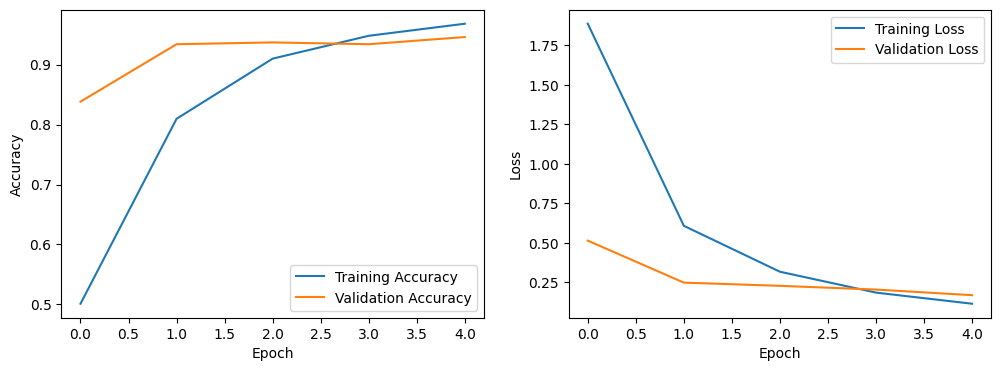

In [29]:
# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# Save the model
model.save('my_model.h5')

In [31]:
# Prediksi Model
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 [==============================] - 23s 2s/step


['eggplant',
 'eggplant',
 'eggplant',
 'eggplant',
 'eggplant',
 'eggplant',
 'eggplant',
 'eggplant',
 'eggplant',
 'eggplant',
 'watermelon',
 'watermelon',
 'watermelon',
 'watermelon',
 'watermelon',
 'watermelon',
 'watermelon',
 'watermelon',
 'watermelon',
 'watermelon',
 'carrot',
 'carrot',
 'carrot',
 'carrot',
 'carrot',
 'carrot',
 'carrot',
 'garlic',
 'garlic',
 'garlic',
 'garlic',
 'garlic',
 'garlic',
 'garlic',
 'garlic',
 'garlic',
 'garlic',
 'potato',
 'sweetpotato',
 'sweetpotato',
 'sweetpotato',
 'sweetpotato',
 'sweetpotato',
 'sweetpotato',
 'sweetpotato',
 'sweetpotato',
 'sweetpotato',
 'capsicum',
 'capsicum',
 'capsicum',
 'capsicum',
 'capsicum',
 'capsicum',
 'capsicum',
 'capsicum',
 'bell pepper',
 'ginger',
 'ginger',
 'ginger',
 'ginger',
 'ginger',
 'ginger',
 'ginger',
 'ginger',
 'ginger',
 'ginger',
 'jalepeno',
 'jalepeno',
 'jalepeno',
 'jalepeno',
 'jalepeno',
 'jalepeno',
 'jalepeno',
 'jalepeno',
 'jalepeno',
 'cabbage',
 'cabbage',
 'cabba

In [ ]:
def output(location):
    img = tf.keras.preprocessing.image.load_img(location, target_size=(128,128))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    answer = model.predict(img)
    y_class = np.argmax(answer, axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    predicted_label = labels[y]
    calories = calorie_dict.get(predicted_label, 'Unknown')
    return predicted_label, calories


In [32]:
# Dictionary of calories
calorie_dict = {
    'cabbage': 25,
    'paprika': 31,
    'cucumber': 16,
    'potato': 77,
    'lettuce': 5,
    'lemon': 29,
    'sweetcorn': 86,
    'corn': 86,
    'pomegranate': 83,
    'pear': 57,
    'turnip': 28,
    'orange': 43,
    'sweetpotato': 86,
    'spinach': 23,
    'chilli pepper': 40,
    'onion': 40,
    'carrot': 41,
    'beetroot': 43,
    'peas': 81,
    'pineapple': 50,
    'kiwi': 41,
    'grapes': 69,
    'garlic': 149,
    'banana': 96,
    'watermelon': 30,
    'jalepeno': 29,
    'soy beans': 173,
    'raddish': 16,
    'ginger': 80,
    'mango': 60,
    'bell pepper': 31,
    'apple': 52,
    'capsicum': 40,
    'cauliflower': 25,
    'eggplant': 25,
    'tomato': 18
}

# Call the output function and retrieve the predicted label and calories
predicted_label, calories = output('/content/DATASET/test/apple/Image_10.jpg')

print('Predicted Class:', predicted_label)
print('Calories:', calories)

1/1 [==============================] - 0s 22ms/step
Predicted Class: apple
Calories: 52


In [ ]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_file = 'my_model.tflite'
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)

print("TFLite model conversion completed successfully.")


In [ ]:
# Simpan model dalam format SavedModel
tf.saved_model.save(model, '/content/saved_model')

# Konversi model ke format .pb
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model')
tflite_model = converter.convert()

# Simpan model .pb
with open('/content/model.pb', 'wb') as f:
    f.write(tflite_model)
